# Calculate the nonstationary internal tide GP/spectral parameters



In [1]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map

from functools import partial
from jax import numpy as np
import jax 
import optax

In [2]:
# s3login = '/home/mrayson/code/s3.acacia.login'
s3login = '/home/jupyter-mrayson/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)


In [3]:
# Speccy jax stuff


def is_even(x):
    return x % 2 == 0

def n_freq(n):
    return int(np.floor(n/2))

def taus(n, delta):
    return delta * np.arange(n)

def fftshift(x):
    return np.fft.fftshift(x)

def fftfreq(n, delta):
    return fftshift(np.fft.fftfreq(n, delta))

def periodogram(ts, delta = 1, h = None):
    
    n = ts.size

    if h is not None:
        norm = np.sum(h**2)
        scale = np.sqrt(n/norm)
        ts = scale * h * ts

    dft = np.fft.fft(ts)/np.sqrt(n/delta)
    
    I = np.real(dft * np.conj(dft))
    ff = np.fft.fftfreq(n, delta)

    return fftshift(ff), fftshift(I)

def whittle(ts, specfunc, params, delta = 1, h = None):
    
    ff, I = periodogram(ts, delta, h)
    S = specfunc(ff, params)

    ll = - (np.log(S) + I/S)
    idx = (ff != 0) * (ff != -0.5/delta)
    
    return np.sum(ll[idx])

def dwhittle(ts, acffunc, params, delta = 1, h = None):
    
    tt = delta * np.arange(ts.size)
    ff, I = periodogram(ts, delta, h)
    ff_boch, S_boch = bochner(acffunc(tt, params), delta = delta, bias = True)
    # HACK: quick fix cause bochner isn't two sided yet
    return - 2 * np.sum(np.log(S_boch[ff_boch > 0]) + I[ff > 0]/S_boch[ff_boch > 0])

def bochner(acf, delta = 1, bias = True, h = None):

    n = np.size(acf)

    if h is not None:
        
        norm = np.sum(h**2)
        h_conv = (np.convolve(h, h, mode = 'full')/norm)[(n-1):]
        acf = h_conv * acf

    elif bias:

        acf = (1 - np.arange(n)/n) * acf

    ff = fftfreq(n, delta)

    if is_even(n):
        acf = np.concatenate([np.array([acf[0]/2]), acf[1:(n-1)], np.array([acf[-1]/2])])
    else:
        acf = np.concatenate([np.array([acf[0]/2]), acf[1:n]])
    
    psd = 2 * delta * np.real(np.fft.fft(acf))

    return ff, fftshift(psd)

In [274]:
# Covariance kernels / ACFs
def calc_dist(x, xpr, eps=1e-14):
    dx2 = np.power(x-xpr, 2.)
    #dx2[dx2<eps] = eps
    #dx2 = dx2.at[dx2<eps].set(eps)
    dx2 = np.where(dx2 < eps, eps, dx2)
    return np.sqrt(dx2)

def cosine(x, xpr, l):
    """Cosine base function"""
    return np.cos(2*np.pi*np.abs(x-xpr)/l)


def gamma_exp(x, xpr, gam, l):
    """γ-exponential covariance function"""
    dx = calc_dist(x, xpr)
    return np.exp(-np.power(dx/l, gam))

def oscillate_1d_gammaexp(x, xpr, params):
    """
    1D Oscillatory kernel
    """
    eta, d, l, gam = params

    return eta**2 * gamma_exp(x, xpr, gam, d) * cosine(x, xpr, l)

def oscillate_D2D1_gammaexp(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2]):

    eta1, d1, eta2, d2, gam1, gam2, constant = params
    

    C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, lt[0], gam1))
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[1], gam2))
    
    #C[0] = C[0] + constant
    C = C.at[0].add(constant)

    return C

def oscillate_D2D1_gammaexp_fixed(x, xpr, params, 
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2],
                                 gam1=1.5, gam2=1.5):

    eta1, d1, eta2, d2, constant = params
    

    C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, lt[0], gam1))
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[1], gam2))
    
    #C[0] = C[0] + constant
    C = C.at[0].add(constant)

    return C

def oscillate_fD2D1_gammaexp(x, xpr, params, 
                     f_cor=2,
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2],
                                 gam=1.5):

    eta1, d1, eta2, d2, eta3, d3 = params
    
    C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, f_cor, gam))
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[0], gam))
    C += oscillate_1d_gammaexp(x, xpr, (eta3, d3, lt[1], gam))

    return C


def itide_meso_gammaexp(x, xpr, params, **kwargs):
    eta_m, l_m, gam_m, eta1, d1,  eta2, d2, eta3, d3 = params

    C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
    C += oscillate_fD2D1_gammaexp(x, xpr, (eta1, d1, eta2, d2, eta3, d3), **kwargs)
    return C

In [275]:
class LogTransformer:
    def __init__(self,params):
        self.params = params

    def __call__(self):
        return np.log(self.params)
    
    def out(self, tparams):
        return np.exp(tparams)

In [363]:
def dwhittle_fast(x, y, ff, I, acffunc, params, delta = 1, h = None, fmin=0, fmax=np.inf, acf_kwargs={}):
    ff_boch, S_boch = bochner(acffunc(x, x[0], params, **acf_kwargs), delta = delta, bias = True)
    # Subset frequencies
    idx = (ff > fmin) & (ff<fmax)
    whit = np.log(S_boch) + I/S_boch
    return -2* np.where(idx, whit, 0).sum()

@jax.value_and_grad
@partial(jax.jit, static_argnums=(5,6,7,8,9))
def loss(logparams,  X, y, f, I, covfunc,  dt, fmin, fmax, Transformer, acf_kwargs):
    params = Transformer.out(logparams)
    return -dwhittle_fast(X, y, f, I, covfunc, params, delta=dt, fmin=fmin, fmax=fmax, acf_kwargs=acf_kwargs) 

def estimate_jax(y, X, covfunc, covparams_ic, fmin, fmax,
                 cov_kwargs={},
                window=None,
                verbose=True,
                maxiter=500,
                ftol=1e-2,
                opt= optax.sgd(learning_rate=3e-4),
                transformer=LogTransformer):

    dt = X[1]-X[0]
    f, I = periodogram(y, delta=dt, h=window)
    idx = (f > fmin) & (f<fmax)
    
    # def dwhittle_jax(params, acffunc):
    #     ff_boch, S_boch = bochner(acffunc(x, x[0], params))
    #     whit = np.log(S_boch) + I/S_boch
    #     return -2* np.where(idx, whit, 0).sum()
    
    # @jax.value_and_grad
    # @partial(jax.jit, static_argnums=(1))
    # def loss2(logparams, covfunc):
    #     params = np.exp(logparams)
    #     return -dwhittle_jax(params, covfunc) 

    T = transformer(np.array(covparams_ic))
    logparams = T()
    
    opt_state = opt.init(logparams)
    loss_val = np.inf
    for i in range(maxiter):
        loss_val_new, grads = loss(logparams, np.array(X), np.array(y), f, I, 
                                   covfunc,  dt, fmin, fmax, T, cov_kwargs)
        #loss_val_new, grads = loss2(logparams, covfunc)
        updates, opt_state = opt.update(grads, opt_state)
        logparams = optax.apply_updates(logparams, updates)
        
        if i % 25 == 0:
            if verbose:
                print(f'step {i}, loss: {loss_val_new}')
                print(np.exp(logparams))
        if np.abs(loss_val_new-loss_val) < ftol:
            if verbose:
                print(f'step {i}, loss: {loss_val}')
            break
    
        loss_val = 1*loss_val_new
        
    #return T.out(logparams), loss_val
    return np.concatenate([T.out(logparams), np.array([loss_val])])


In [348]:


invarname = 'eta'
# invarname = 'vc'
# invarname = 'uc'

zarrin = 'NWS_2km_GLORYS_2013_2014_{}_seasonaltides.zarr'.format(invarname)
varname = '{}_non_phase_locked'.format(invarname)
dropvars=['{}_non_phase_locked'.format(invarname),'{}_phase_locked'.format(invarname)]




In [349]:
f = S3Map("uwaoceanprocesses-suntans/"+zarrin, s3=s3)

ds = xr.open_dataset(f, engine='zarr', chunks={})

# These need filling in??
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values

ds

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:               (Nc: 225368, numsides: 8, Nk: 80, time: 8761,
                           Np: 454016)
Coordinates:
  * time                  (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-...
    z_r                   (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells                 (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv                    (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz                    (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    eta_non_phase_locked  (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    eta_phase_locked      (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    nfaces                (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    xp                    (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv                    (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp                    (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv                    (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [350]:
import numpy as onp

def extract_point(xpt, ypt):
    dist = onp.abs( (ds.xv.values-xpt) + 1j*(ds.yv.values-ypt))
    idx = onp.argwhere(dist==dist.min())[0,0]

    return ds.isel(Nc=idx).drop_vars(['xp','yp','cells'])


In [351]:
t1,t2 = '2013-07-15','2014-07-01'
# t1,t2 = '2014-01-02','2014-01-30'
myds = xr.concat([
             extract_point(114.2,-20.5), # Lower NWS (high submesoscale)?
             extract_point(115.6,-9.1), # Lombok
                extract_point(122.8,-12.7),
                extract_point(123.1,-12.9),
                extract_point(114.6,-11.7),
                extract_point(114.1,-10.6),
                extract_point( 120.592, -11.567),
                extract_point( 119.609, -13.042),
                extract_point( 112.619, -13.996),
                  extract_point( 115, -10.),
                    extract_point( 123.1391, -13.9329),
                  extract_point( 122.8290, -13.9881),
                  extract_point( 123.0319, -14.2290),

                 ], dim='Nc').sel(time=slice(t1,t2))
myds

<xarray.Dataset>
Dimensions:               (Nc: 13, Nk: 80, time: 8425)
Coordinates:
  * time                  (time) datetime64[ns] 2013-07-15 ... 2014-07-01
    z_r                   (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, Nk
Data variables:
    dv                    (Nc) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dz                    (Nc, Nk) float64 dask.array<chunksize=(1, 80), meta=np.ndarray>
    eta_non_phase_locked  (Nc, time) float64 dask.array<chunksize=(1, 8425), meta=np.ndarray>
    eta_phase_locked      (Nc, time) float64 dask.array<chunksize=(1, 8425), meta=np.ndarray>
    nfaces                (Nc) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    xv                    (Nc) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    yv                    (Nc) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [352]:
idx = 7
y = myds[varname].isel(Nc=idx)

tdays = (myds.time-myds.time[0]).values.astype(float)/1e9/86400
X = tdays#[:,None]
dt = X[1]-X[0]

f_cor = 4*onp.pi/86400*onp.sin(-myds['yv'].isel(Nc=idx).values*onp.pi/180)
f_cor_cpd =2*np.pi/f_cor/86400
f_cor_cpd

2.2155117236199686

In [353]:
####
eta1 = 0.01
eta2 = 0.005
eta3 = 0.01
dt1 = 5.
dt2 = 2.0
dt3 = 2.

eta_m = 0.1
l_m = 0.1
gam_m = 0.5

# f_cor = 2.
# covfunc=oscillate_fD2D1_gammaexp
covfunc=itide_meso_gammaexp

fmin = 1e-3 #0.7
fmax = 2.5 #

covparams = (eta_m, l_m, gam_m, eta1, dt1, eta2, dt2, eta3, dt3,)
# paramnames = ['η1','ℓ1', 'η2','ℓ2','η3','ℓ3']

cov_kwargs={'f_cor':f_cor_cpd}

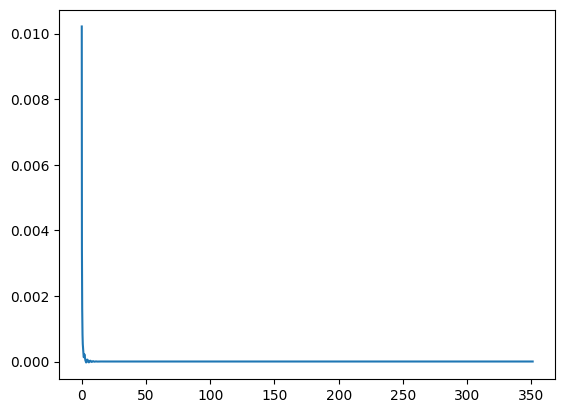

In [354]:
acf = covfunc(X, X[0], covparams, **cov_kwargs)

plt.figure()
plt.plot(X-X[0], acf)

Text(0.5, 0, 'f [cpd]')

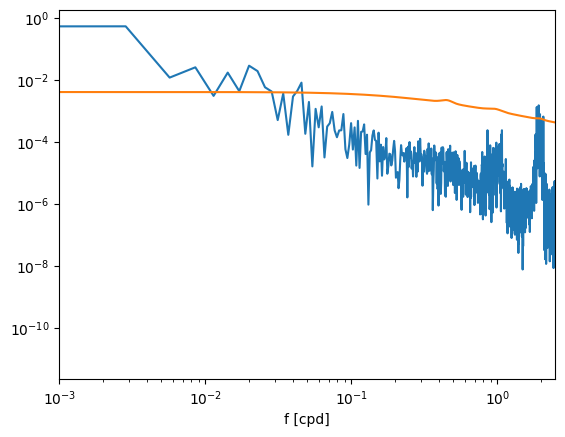

In [355]:
f, I = periodogram(y.values, dt)
f_S, S = bochner(acf, delta=dt)
plt.figure()
# plt.semilogy(f, I)
# plt.semilogy(f_S,S)
plt.loglog(f, I)
plt.loglog(f_S,S)
plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')

In [364]:
%%time
params = estimate_jax(y.values, X, covfunc, covparams, fmin, fmax,
                      cov_kwargs=cov_kwargs,
                      maxiter=500,
                     opt= optax.adabelief(learning_rate=1e-1),
                     #opt= optax.sgd(learning_rate=3e-4),
                     verbose=True)
params

step 0, loss: -11759.669921875
[9.04837921e-02 1.10517025e-01 4.52419013e-01 9.04837903e-03
 5.52585077e+00 4.52418951e-03 2.21034026e+00 9.04837903e-03
 2.21034026e+00]
step 25, loss: -16549.541015625
[2.5030272e-02 1.2210848e+00 1.3661447e-01 5.2917498e-04 3.8161945e+01
 1.0975914e-02 3.8268161e+00 9.7467791e-04 7.3298745e+00]
step 50, loss: -17220.04296875
[1.8100409e-02 1.7040140e+01 3.2420051e-01 2.9895623e-04 4.7829659e+01
 9.5210904e-03 4.3556914e+00 1.1417510e-03 6.6762447e+00]
step 75, loss: -18109.236328125
[3.6296047e-02 1.8040602e+01 1.1168214e+00 4.9792597e-04 7.6134460e+01
 9.0363966e-03 4.4529042e+00 3.5585200e-03 2.6585584e+00]
step 100, loss: -18165.2265625
[4.7020096e-02 2.0265917e+01 1.2902999e+00 1.8437622e-03 3.8904731e+00
 9.0907346e-03 4.4275770e+00 4.0848115e-03 2.5134666e+00]
step 118, loss: -18198.98828125
CPU times: user 1.44 s, sys: 84.2 ms, total: 1.52 s
Wall time: 1.55 s


Array([ 4.9566962e-02,  2.3383846e+01,  1.3572172e+00,  2.9437160e-03,
        2.3072567e+00,  9.2487615e-03,  4.4747157e+00,  3.9736889e-03,
        2.5626717e+00, -1.8198988e+04], dtype=float32)

Text(0.5, 0, 'f [cpd]')

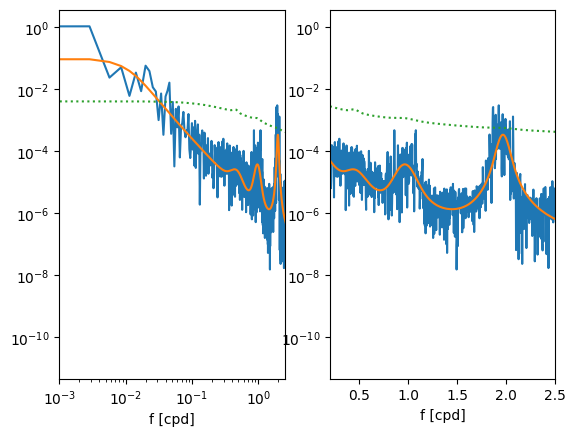

In [365]:
acf = covfunc(X, X[0], params[:-1], **cov_kwargs)
f_S, S = bochner(acf, delta=dt)

acf = covfunc(X, X[0], covparams,**cov_kwargs)
f_S, Si = bochner(acf, delta=dt)

plt.figure()
plt.subplot(121)
plt.loglog(f, 2*I)
plt.loglog(f_S,S)
plt.loglog(f_S,Si,':')

plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')

plt.subplot(122)
plt.semilogy(f, 2*I)
plt.semilogy(f_S,S)
plt.semilogy(f_S,Si,':')

plt.xlim(0.2, fmax)
plt.xlabel('f [cpd]')

# Try dask

In [295]:
from dask.diagnostics import ProgressBar

In [379]:
myds2=ds.isel(Nc=slice(1000,1010)).sel(time=slice(t1,t2))
myds2

<xarray.Dataset>
Dimensions:               (Nc: 10, numsides: 8, Nk: 80, time: 8425, Np: 454016)
Coordinates:
  * time                  (time) datetime64[ns] 2013-07-15 ... 2014-07-01
    z_r                   (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells                 (Nc, numsides) int32 dask.array<chunksize=(10, 8), meta=np.ndarray>
    dv                    (Nc) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    dz                    (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    eta_non_phase_locked  (time, Nc) float64 dask.array<chunksize=(8425, 10), meta=np.ndarray>
    eta_phase_locked      (time, Nc) float64 dask.array<chunksize=(8425, 10), meta=np.ndarray>
    nfaces                (Nc) int32 dask.array<chunksize=(10,), meta=np.ndarray>
    xp                    (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv                    (Nc) float64 dask.array<chunksize=(10,), meta=np.ndarray>
    yp                    (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv                    (Nc) float64 dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [380]:
%%time
window=None
inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax)

def estimate_spectral_params_jax(y, lat, X=X, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax):
    #print(lat)
    f_cor = 4*onp.pi/86400*onp.sin(np.abs(lat)*onp.pi/180)
    f_cor_cpd =2*np.pi/f_cor/86400
    
    params = estimate_jax(y, X, covfunc, covparams, fmin, fmax,
                         cov_kwargs={'f_cor':f_cor_cpd},
                          maxiter=500,
                         opt= optax.adabelief(learning_rate=1e-1),
                         verbose=False)

    #return params
    return np.concatenate([params, np.array([f_cor_cpd]) ])

print('\tBuilding the dask graph...')
params= xr.apply_ufunc(estimate_spectral_params_jax,
                      myds2[varname],
                      myds2['yv'],
                      dask='parallelized',
                      kwargs=inputs,
                      output_dtypes=[y.dtype],
                      input_core_dims=(['time',],[]),
                      output_core_dims=(['params'],),
                      #output_sizes=,
                      dask_gufunc_kwargs={'output_sizes':{'params':len(covparams)+2}},
                      vectorize=True,
                     )

with ProgressBar():
    params = params.compute()
params

	Building the dask graph...
[########################################] | 100% Completed | 18.23 ss
CPU times: user 28.5 s, sys: 622 ms, total: 29.1 s
Wall time: 18.2 s


<xarray.DataArray (Nc: 10, params: 11)>
array([[ 7.02037066e-02,  1.36630955e+01,  1.41624665e+00,
         1.18473126e-03,  2.78562374e+01,  1.14308456e-02,
         4.19023132e+00,  4.42574918e-03,  2.75044870e+00,
        -1.72431367e+04,  3.01754904e+00],
       [ 6.76828697e-02,  1.27853327e+01,  1.42498970e+00,
         1.46297575e-03,  5.34299850e+01,  1.11890119e-02,
         4.16200590e+00,  4.41409415e-03,  2.82470512e+00,
        -1.72983848e+04,  2.98103023e+00],
       [ 6.60183057e-02,  1.32023144e+01,  1.41468072e+00,
         1.24564744e-03,  1.38574677e+02,  1.10208271e-02,
         4.13098955e+00,  4.47574072e-03,  2.78095198e+00,
        -1.73486562e+04,  2.94519138e+00],
       [ 6.51796311e-02,  1.31375275e+01,  1.42002654e+00,
         1.19124865e-03,  2.83851242e+01,  1.09085068e-02,
         4.13839817e+00,  4.45711194e-03,  2.77282548e+00,
        -1.73863770e+04,  2.91006851e+00],
       [ 6.50887713e-02,  1.30215054e+01,  1.42527151e+00,
         4.57266928e-04,  1.15618591e+01,  1.08870715e-02,
         4.15268660e+00,  4.34090057e-03,  2.74473906e+00,
        -1.74160859e+04,  2.87559366e+00],
       [ 6.51447549e-02,  1.26548901e+01,  1.44691920e+00,
         3.25357425e-04,  7.71992111e+00,  1.09284427e-02,
         4.18612003e+00,  4.27984353e-03,  2.56538844e+00,
        -1.74396934e+04,  2.84190750e+00],
       [ 6.62855729e-02,  1.25923758e+01,  1.45979524e+00,
         2.72147707e-04,  7.23389959e+00,  1.09797716e-02,
         4.22319317e+00,  4.26768977e-03,  2.61980796e+00,
        -1.74641289e+04,  2.80888510e+00],
       [ 6.77154437e-02,  1.23343992e+01,  1.49066401e+00,
         2.85714719e-04,  2.52594391e+02,  1.09191081e-02,
         4.23597431e+00,  4.40955441e-03,  2.75190377e+00,
        -1.74850176e+04,  2.77654409e+00],
       [ 7.01138452e-02,  1.25219841e+01,  1.50572991e+00,
         2.42882161e-04,  2.18153320e+02,  1.09082991e-02,
         4.25632477e+00,  4.30289702e-03,  2.69364238e+00,
        -1.75008477e+04,  2.74491310e+00],
       [ 7.29043931e-02,  1.26276960e+01,  1.51945615e+00,
         2.71868339e-04,  4.06931267e+01,  1.08944876e-02,
         4.26865196e+00,  4.21902956e-03,  2.60656881e+00,
        -1.75064062e+04,  2.71397805e+00]])
Dimensions without coordinates: Nc, params

# Testing below here...

In [222]:
# This is hard-wired to the case above
def dwhittle_fast(x, y, ff, I, acffunc, params, delta = 1, h = None, fmin=0, fmax=np.inf):

    ff_boch, S_boch = bochner(acffunc(x, x[0], params), delta = delta, bias = True)

    # Subset frequencies
    #idx_boch = (ff_boch > fmin) & (ff_boch<fmax)
    idx = (ff > fmin) & (ff<fmax)

    # HACK: quick fix cause bochner isn't two sided yet
    whit = np.log(S_boch) + I/S_boch
    return -2* np.where(idx, whit, 0).sum()
    #return - 2 * np.sum(np.log(S_boch[idx]) + I[idx]/S_boch[idx])

@jax.value_and_grad
@partial(jax.jit, static_argnums=(5,6,7,8))
def loss(logparams,  X, y, f, I, covfunc,  dt, fmin, fmax):
    params = np.exp(logparams)
    return -dwhittle_fast(X, y, f, I, covfunc, params, delta=dt, fmin=fmin, fmax=fmax) 
    

In [223]:
dwhittle_fast(X, y.values, f, I, covfunc, covparams, fmin=fmin, fmax=fmax)

Array(94.04004, dtype=float32)

In [226]:
x=X
idx = (f > fmin) & (f<fmax)
def dwhittle_jax(params, acffunc):

    ff_boch, S_boch = bochner(acffunc(x, x[0], params))

    whit = np.log(S_boch) + I/S_boch
    return -2* np.where(idx, whit, 0).sum()

@jax.value_and_grad
@partial(jax.jit, static_argnums=(1))
def loss2(logparams, covfunc):
    params = np.exp(logparams)
    return -dwhittle_jax(params, covfunc) 

In [227]:
logparams = np.log(np.array(covparams))
# loss(logparams, np.array(X), np.array(y.values), f, I, covfunc,  dt, fmin, fmax)
loss2(logparams, covfunc)

(Array(-94.02051, dtype=float32),
 Array([-10123.3955,   6188.308 ,  -5100.722 ,   4073.4658,  -2464.0906],      dtype=float32))

In [229]:
%%time
opt = optax.sgd(learning_rate=3e-4)
# opt = optax.adam(learning_rate=1e-1)

opt_state = opt.init(logparams)
loss_val = np.inf
for i in range(500):
    #loss_val_new, grads = loss(logparams, np.array(X), np.array(y.values), f, I, covfunc,  dt, fmin, fmax)
    loss_val_new, grads = loss2(logparams, covfunc)
    updates, opt_state = opt.update(grads, opt_state)
    logparams = optax.apply_updates(logparams, updates)
    if i % 10 == 0:
        print(f'step {i}, loss: {loss_val_new}')
        print(np.exp(logparams))
    if np.abs(loss_val_new-loss_val) < 1e-2:
        print(f'step {i}, loss: {loss_val}')
        break

    loss_val = 1*loss_val_new


step 0, loss: -94.0205078125
[3.1264520e-01 1.5621961e+00 4.6191774e-03 2.9462857e+00 2.0943162e-06]
step 10, loss: -8574.44921875
[1.6673638e-02 1.0366410e+01 3.9194878e-03 1.9094799e+00 2.1366334e-06]
step 20, loss: -8687.0068359375
[1.4606985e-02 9.8059378e+00 3.3099456e-03 1.1555848e+00 2.2024378e-06]
step 30, loss: -8717.005859375
[1.3002753e-02 8.9476681e+00 3.2535247e-03 9.1621125e-01 2.2328136e-06]
step 40, loss: -8727.3828125
[1.1769324e-02 8.0455027e+00 3.2717658e-03 8.3886057e-01 2.2491135e-06]
step 50, loss: -8733.923828125
[1.0806603e-02 7.2658005e+00 3.2842890e-03 8.0960006e-01 2.2608058e-06]
step 60, loss: -8738.2978515625
[1.0082160e-02 6.6614285e+00 3.2905014e-03 7.9747480e-01 2.2707673e-06]
step 70, loss: -8740.84765625
[9.5710391e-03 6.2306075e+00 3.2931133e-03 7.9241145e-01 2.2799309e-06]
step 80, loss: -8742.107421875
[9.2338538e-03 5.9446020e+00 3.2938782e-03 7.9052067e-01 2.2886709e-06]
step 90, loss: -8742.646484375
[9.0235481e-03 5.7651720e+00 3.2938216e-03 7.9

Text(0.5, 0, 'f [cpd]')

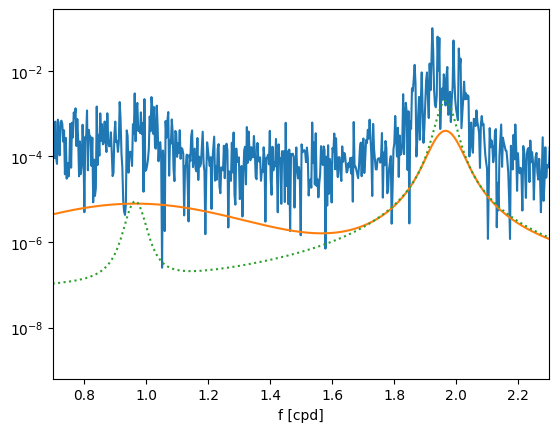

In [230]:
acf = covfunc(X, X[0], np.exp(logparams))
f_S, S = bochner(acf, delta=dt)

acf = covfunc(X, X[0], covparams)
f_S, Si = bochner(acf, delta=dt)

plt.figure()
plt.semilogy(f, 2*I)
plt.semilogy(f_S,S)
plt.semilogy(f_S,Si,':')

plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')

step 0, loss: 253890.65625
[1.0177167e+35 2.0136395e-22 8.2618419e+13 5.2516368e-13 9.8452469e+01]
step 10, loss: nan
[nan nan nan nan nan]
step 20, loss: nan
[nan nan nan nan nan]
step 30, loss: nan
[nan nan nan nan nan]
step 40, loss: nan
[nan nan nan nan nan]
step 50, loss: nan
[nan nan nan nan nan]
step 60, loss: nan
[nan nan nan nan nan]
step 70, loss: nan
[nan nan nan nan nan]
step 80, loss: nan
[nan nan nan nan nan]
step 90, loss: nan
[nan nan nan nan nan]
step 100, loss: nan
[nan nan nan nan nan]
step 110, loss: nan
[nan nan nan nan nan]
step 120, loss: nan
[nan nan nan nan nan]
step 130, loss: nan
[nan nan nan nan nan]
step 140, loss: nan
[nan nan nan nan nan]
step 150, loss: nan
[nan nan nan nan nan]
step 160, loss: nan
[nan nan nan nan nan]
step 170, loss: nan
[nan nan nan nan nan]
step 180, loss: nan
[nan nan nan nan nan]
step 190, loss: nan
[nan nan nan nan nan]
step 200, loss: nan
[nan nan nan nan nan]
step 210, loss: nan
[nan nan nan nan nan]
step 220, loss: nan
[nan nan

Array([nan, nan, nan, nan, nan], dtype=float32)

Text(0.5, 0, 'f [cpd]')

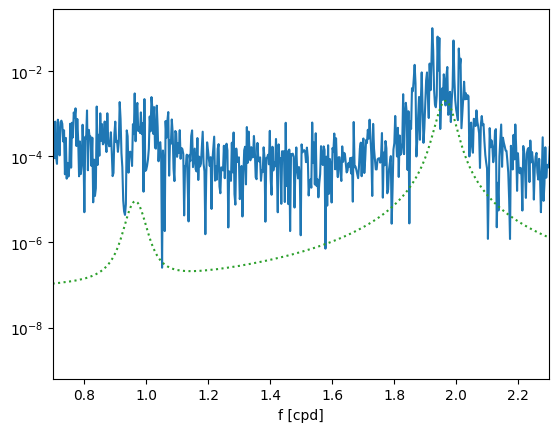

In [233]:
acf = covfunc(X, X[0], params)
f_S, S = bochner(acf, delta=dt)

acf = covfunc(X, X[0], covparams)
f_S, Si = bochner(acf, delta=dt)

plt.figure()
plt.semilogy(f, 2*I)
plt.semilogy(f_S,S)
plt.semilogy(f_S,Si,':')

plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')